In [ ]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx
from node2vec import Node2Vec
import pandas as pd

In [69]:
df = pd.read_csv("../data/external/congress_trading_data_adrianmross.csv")

In [70]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["type"] = df["type"].replace({"sale_partial": "sale", "sale_full": "sale"})

In [71]:
df["transaction_date"].min(), df["transaction_date"].max()

(Timestamp('2012-06-19 00:00:00'), Timestamp('2023-12-22 00:00:00'))

In [72]:
trade_amounts = {}
for year in range(df["transaction_date"].min().year, df["transaction_date"].max().year + 1):
    yearly_trades = df[df["transaction_date"].dt.year == year]
    trade_amounts[year] = len(yearly_trades)

print(len(df))
print(trade_amounts)

23283
{2012: 3, 2013: 4, 2014: 18, 2015: 625, 2016: 764, 2017: 1067, 2018: 1109, 2019: 1812, 2020: 7996, 2021: 5550, 2022: 3499, 2023: 836}


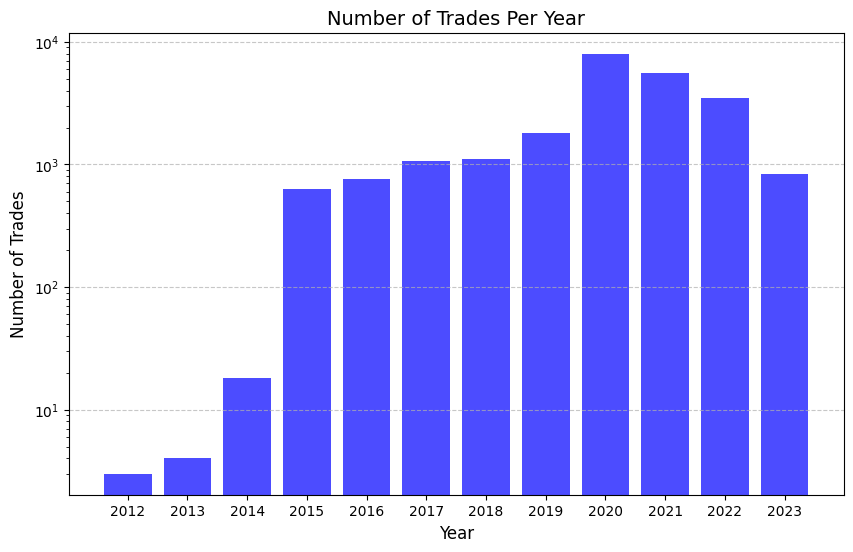

In [73]:
plt.figure(figsize=(10, 6))
plt.bar(list(trade_amounts.keys()), list(trade_amounts.values()), color="blue", alpha=0.7)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Trades", fontsize=12)
plt.title("Number of Trades Per Year", fontsize=14)
plt.xticks(list(trade_amounts.keys()), fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.yscale("log")

In [74]:
train_len = 0.8 * len(df)
test_len = 0.2 * len(df)
print(train_len, test_len)

18626.4 4656.6


It makes sense to take 2022 and 2023 as the test set, and the rest as the training set. 

## Train-Test Split

In [75]:
df = df[df["transaction_date"].dt.year > 2013]
train_end_date = datetime.strptime("2022-01-01", "%Y-%m-%d").year

df_train = df[df["transaction_date"].dt.year < train_end_date]
df_test = df[df["transaction_date"].dt.year > train_end_date]
print(df_train.head())

  disclosure_date transaction_date ticker      type             amount  \
0      2021-10-04       2021-09-27     BP  purchase   $1,001 - $15,000   
1      2021-10-04       2021-09-13    XOM  purchase   $1,001 - $15,000   
2      2021-10-04       2021-09-10   ILPT  purchase  $15,001 - $50,000   
3      2021-10-04       2021-09-28     PM  purchase  $15,001 - $50,000   
4      2021-10-04       2021-09-17    BLK      sale   $1,001 - $15,000   

                name                                  asset_description state  \
0      Virginia Foxx                                             BP plc    NC   
1      Virginia Foxx                            Exxon Mobil Corporation    NC   
2      Virginia Foxx  Industrial Logistics Properties Trust - Common...    NC   
3      Virginia Foxx                   Phillip Morris International Inc    NC   
4  Alan S. Lowenthal                                      BlackRock Inc    CA   

        party                            industry                 se

In [76]:
def create_graph(df: pd.DataFrame) -> nx.Graph:
    G = nx.Graph()

    party_colors = {"Democrat": "blue", "Republican": "red"}
    party_map = {row["name"]: row["party"] for _, row in df.iterrows()}

    for rep in df["name"].unique():
        G.add_node(
            rep, color=party_colors.get(party_map[rep], "gray")
        )  # Default to gray if party unknown

    for ticker in df["ticker"].unique():
        ticker_trades = df[df["ticker"] == ticker]

        for i in range(len(ticker_trades)):
            for j in range(i + 1, len(ticker_trades)):
                rep1 = ticker_trades.iloc[i]["name"]
                rep2 = ticker_trades.iloc[j]["name"]
                date1 = ticker_trades.iloc[i]["transaction_date"]
                date2 = ticker_trades.iloc[j]["transaction_date"]
                trans_type1 = ticker_trades.iloc[i]["type"]
                trans_type2 = ticker_trades.iloc[j]["type"]

                if rep1 != rep2 and abs((date1 - date2).days) <= 7 and trans_type1 == trans_type2:
                    G.add_edge(rep1, rep2, stock=ticker)

    return G

In [77]:
G_train = create_graph(df_train)
G_test = create_graph(df_test)

In [78]:
def export_graph(folder, filename, file) -> None:
    os.makedirs(folder, exist_ok=True)
    nx.write_gml(file, f"../{folder}/{filename}")
    print(f"GML file saved as {folder}/{filename}")


folder = "data/internal/networks/ml"
export_graph(folder, "train_7d.gml", G_train)
export_graph(folder, "test_7d.gml", G_test)

GML file saved as data/internal/networks/ml/train_7d.gml
GML file saved as data/internal/networks/ml/test_7d.gml


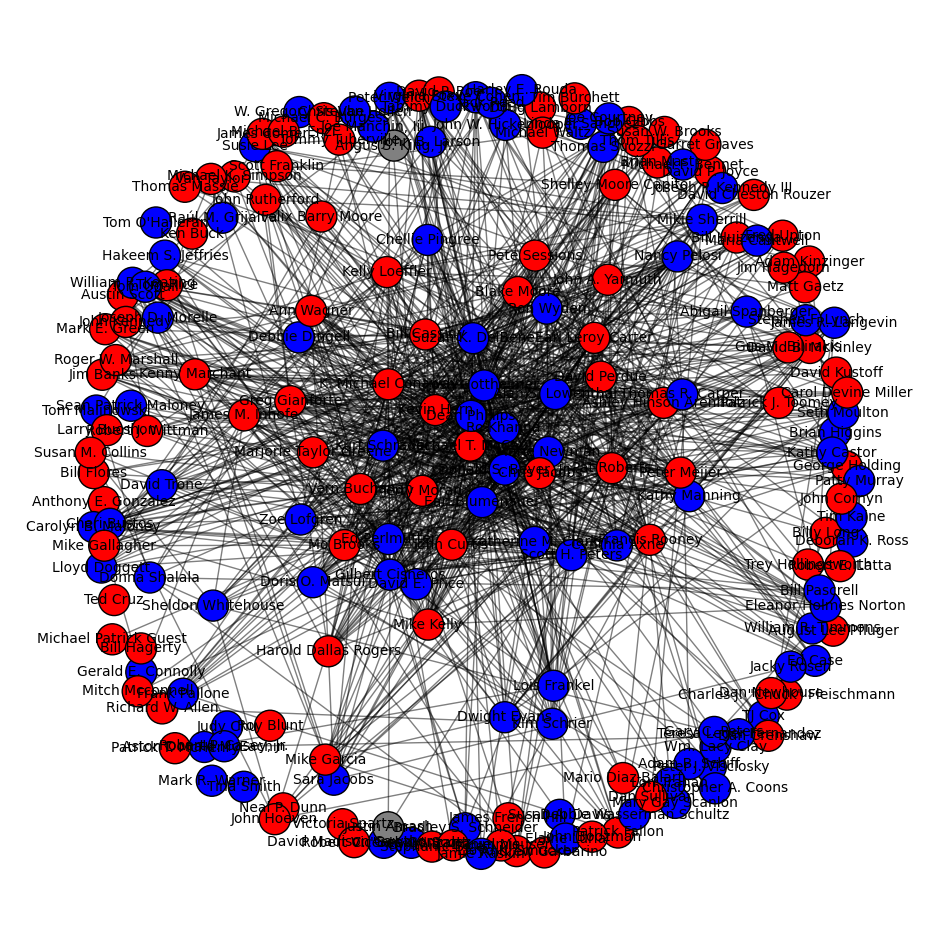

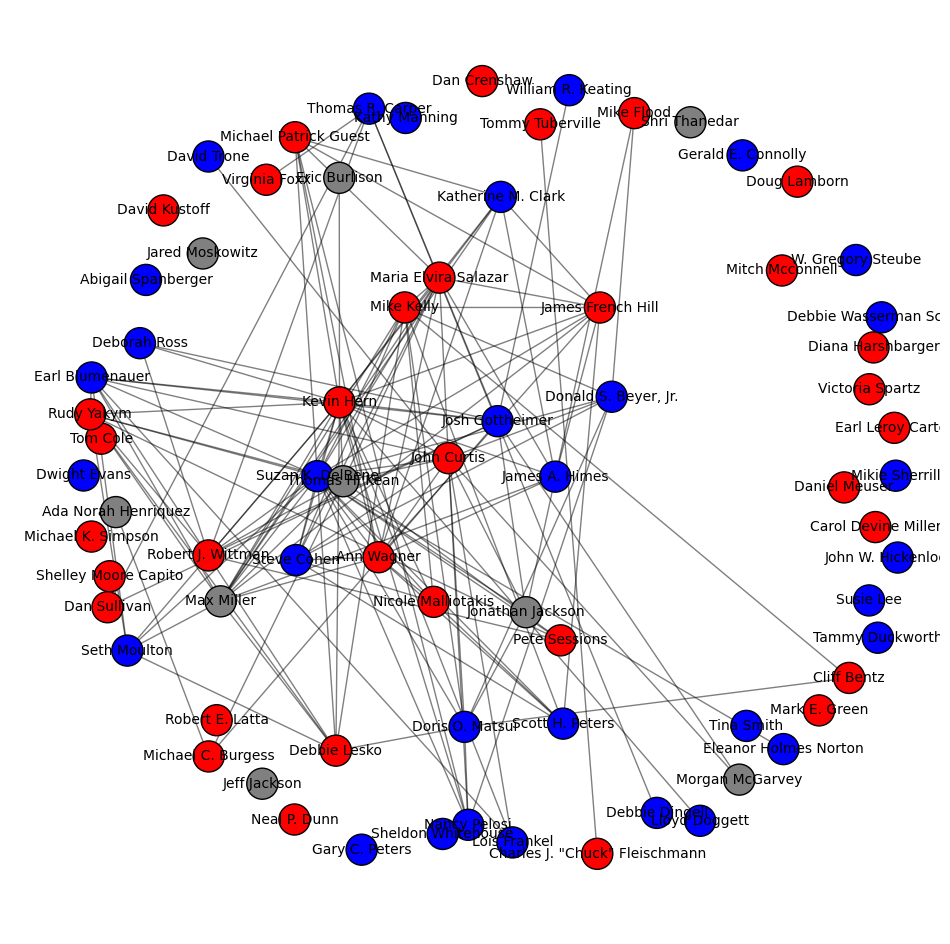

In [79]:
def plot_graph(G):
    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G, seed=42, k=1.5)

    node_colors = [data["color"] for _, data in G.nodes(data=True)]

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.axis("off")
    plt.show()


plot_graph(G_train)
plot_graph(G_test)

In [80]:
print(len(G_train.nodes), len(G_train.edges), len(G_test.nodes), len(G_test.edges))

201 1158 75 140


## Create Embeddings using Node2Vec

In [81]:
node2vec_train = Node2Vec(G_train, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_train = node2vec_train.fit(window=10, min_count=1)

embeddings_train = pd.DataFrame(
    [model_train.wv.get_vector(str(node)) for node in G_train.nodes()], index=G_train.nodes
)
embeddings_train.index.name = "name"
embeddings_train.reset_index(inplace=True)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 90.14it/s]


In [82]:
node2vec_test = Node2Vec(G_test, dimensions=64, walk_length=30, num_walks=200, workers=4)
model_test = node2vec_test.fit(window=10, min_count=1)

embeddings_test = pd.DataFrame(
    [model_test.wv.get_vector(str(node)) for node in G_test.nodes()], index=G_test.nodes
)
embeddings_test.index.name = "name"
embeddings_test.reset_index(inplace=True)

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 558.06it/s]


In [83]:
df_returns = pd.read_csv("../data/external/congress_returns_adrianmross.csv")
df_returns["date"] = pd.to_datetime(df_returns["date"])
print(df_returns.head())

                 name       date    return  cum_return
0  Abigail Spanberger 2021-06-01  0.000000    0.000000
1  Abigail Spanberger 2021-06-02  0.007044    0.007044
2  Abigail Spanberger 2021-06-03  0.005578    0.012662
3  Abigail Spanberger 2021-06-04  0.012776    0.025600
4  Abigail Spanberger 2021-06-05  0.000000    0.025600


In [107]:
returns_train = df_returns[df_returns["date"].dt.year < train_end_date]
returns_test = df_returns[df_returns["date"].dt.year > train_end_date]

member_active_periods = (
    returns_train.groupby("name")
    .agg(start_date=("date", "min"), end_date=("date", "max"))
    .reset_index()
)

member_active_periods_test = (
    returns_test.groupby("name")
    .agg(start_date=("date", "min"), end_date=("date", "max"))
    .reset_index()
)


# Calculate historical return metrics for each member
def calculate_historical_returns(historical_returns):
    metrics = historical_returns.groupby("name").agg({"return": ["mean", "std", "sum"]})
    metrics.columns = ["avg_return", "return_volatility", "cumulative_return"]
    metrics.reset_index(inplace=True)
    return metrics


historical_returns_train = calculate_historical_returns(returns_train)
historical_returns_train = pd.merge(
    historical_returns_train, member_active_periods, on="name", how="left"
)
historical_returns_test = calculate_historical_returns(returns_test)
historical_returns_test = pd.merge(
    historical_returns_test, member_active_periods_test, on="name", how="left"
)

we need to normalize the cum. return b.c. not all members have been active for the same amount of time.

In [108]:
df_sp500 = pd.read_csv("../data/external/s&p500_returns_adrianmross.csv")
df_sp500["date"] = pd.to_datetime(df_sp500["date"])

In [109]:
def calculate_sp500_cumulative_return(start_date, end_date):
    mask = (df_sp500["date"] >= start_date) & (df_sp500["date"] <= end_date)
    sp500_period = df_sp500.loc[mask]
    cumulative_return = sp500_period["daily_return"].sum()
    return cumulative_return

In [111]:
historical_returns_train["sp500_cumulative_return"] = historical_returns_train.apply(
    lambda row: calculate_sp500_cumulative_return(row["start_date"], row["end_date"]), axis=1
)
historical_returns_train["normalized_return"] = (
    historical_returns_train["cumulative_return"]
    - historical_returns_train["sp500_cumulative_return"]
)

historical_returns_test["sp500_cumulative_return"] = historical_returns_test.apply(
    lambda row: calculate_sp500_cumulative_return(row["start_date"], row["end_date"]), axis=1
)
historical_returns_test["normalized_return"] = (
    historical_returns_test["cumulative_return"]
    - historical_returns_test["sp500_cumulative_return"]
)

In [112]:
features_train = pd.merge(embeddings_train, historical_returns_train, on="name", how="left")
features_train.fillna(0, inplace=True)
Y_train = historical_returns_train[["name"]]
training_data = pd.merge(features_train, Y_train, on="name")

features_test = pd.merge(embeddings_test, historical_returns_test, on="name", how="left")
features_test.fillna(0, inplace=True)
Y_test = historical_returns_test[["name"]]
test_data = pd.merge(features_test, Y_test, on="name")

/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_52979/2075753384.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  features_train.fillna(0, inplace=True)
/var/folders/zd/5rj11nhj5h98j5kmp_lp5k5w0000gn/T/ipykernel_52979/2075753384.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  features_test.fillna(0, inplace=True)


In [113]:
training_data.to_csv("../data/internal/ml/train_7d.csv", index=False)
test_data.to_csv("../data/internal/ml/test_7d.csv", index=False)